In [111]:
import networkx as nx
from nltk import word_tokenize, pos_tag, download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

In [112]:
# download relevant nltk datasets
download("wordnet")
download("omw-1.4")
download("punkt")
download("averaged_perceptron_tagger")
download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [113]:
# load pages
with open("cains_jawbone.txt", "r", encoding="utf-8") as f:
    pages = f.read().split("\n\n")

In [114]:
# preprocess and tokenize pages
lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words("english"))

def get_pos(tag: str) -> str | None:
    match tag[0]:
        case "J":
            return wordnet.ADJ
        case "R":
            return wordnet.ADV
        case "N":
            return wordnet.NOUN
        case "V":
            return wordnet.VERB
        case _:
            return None

def preprocess(text: str) -> str:
    tokens = [token for token in word_tokenize(text.lower())]
    tagged = [(word, get_pos(tag)) for word, tag in pos_tag(tokens)]
    lemmatized = [lemmatizer.lemmatize(word, pos=tag) for (word, tag) in tagged if tag is not None]
    return " ".join(lemmatized)
    # words = [word for word in lemmatized if len(word) > 2 and word not in stop_words and word.isalpha()]
    # return " ".join(words)

data = [preprocess(page) for page in pages]

In [115]:
# vectorize tokens to frequencies
vectorizer = TfidfVectorizer()
freqs = vectorizer.fit_transform(data)

In [116]:
# calculate cosine similarities between pages
weights = np.zeros((len(pages), len(pages)))
stats = []
for i in range(len(pages)):
    for j in range(len(pages)):
        weight = cosine_similarity(freqs[i], freqs[j]).flatten()[0]
        weights[i, j] = weight
        if i > j:
            stats.append(weight)

In [117]:
stats = np.array(stats)

In [118]:
print(stats.min(), stats.mean(), stats.max(), stats.std())

0.019894622187133587 0.08425618893009772 0.3300537936923397 0.029549702772006203


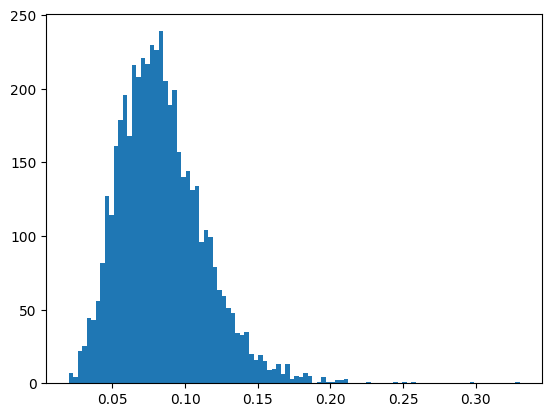

In [119]:
plt.hist(stats, bins=100)
plt.show()

In [10]:
def generate_graph(weights: np.ndarray, threshold: float = 0.03) -> nx.Graph:
    n = weights.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if weights[i, j] >= threshold:
                G.add_edge(i, j)
    return G

In [11]:
G = generate_graph(weights, 0.05)

In [12]:
len(G.edges)

687

In [13]:
def n_communities(G: nx.Graph) -> float:
    return len(nx.community.louvain_communities(G))

In [14]:
n_communities(G)

7

In [41]:
# or alternatively with whole weighted graph
G = nx.complete_graph(len(pages))
for (i, j) in G.edges:
    G.edges[i, j]["weight"] = cosine_similarity(freqs[i], freqs[j]).flatten()[0]

communities = nx.community.louvain_communities(G, weight="weight")

In [42]:
len(communities)

5

Communities

- 15 16 33 42 44 51 77 82 83 97 
- 0 6 8 13 14 19 24 27 30 49 50 59 61 81 85 88 94 95 
- 1 3 4 10 12 20 37 39 40 41 43 46 48 52 57 60 62 65 67 71 72 75 76 79 84 86 89 92 93 96 99 
- 5 11 17 22 23 25 26 29 34 35 36 53 54 55 58 68 70 73 74 80 90 91 98 
- 2 7 9 18 21 28 31 32 38 45 47 56 63 64 66 69 78 87 

NMF

- 19 27 32 39 46 64 65 75 77 80 92
- 2 7 9 18 21 38 45 47 56 63 69 78 87
- 11 23 26 28 29 35 37 52 53 55 58 68 70 73 74 88 89 98
- 1 3 10 13 20 24 25 30 31 34 41 48 57 62 71 76 79 81 84 86 93 96 99
- 4 5 12 15 16 17 22 33 40 42 43 44 51 54 60 61 67 72 82 83 91 97
- 0 6 8 14 36 49 50 59 66 85 90 94 95

In [17]:
# plot complete graph with similarity as opacity for edges and colors for communities (and/or grouping in layout)

In [65]:
# https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [67]:
comm_dict = {}
for community_index, community in enumerate(communities):
    for node in community:
        comm_dict[node] = community_index
pos = community_layout(G, comm_dict)

C:\Users\maxst\AppData\Local\Temp\ipykernel_21892\117404220.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("viridis", len(unique_colors)),


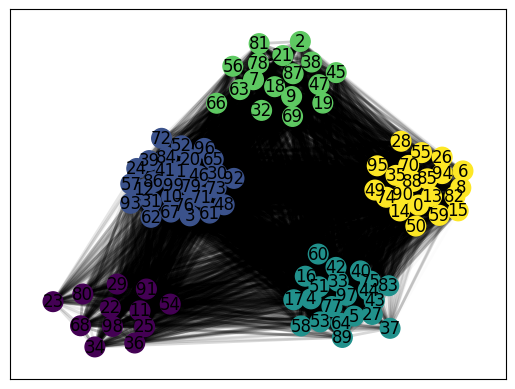

In [68]:
# Create a mapping dictionary to assign colors to nodes based on their community
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = i

# Get unique community colors
unique_colors = set(node_colors.values())

# Normalize the edge weights between 0 and 1
edge_weights = nx.get_edge_attributes(G, 'weight')
max_weight = max(edge_weights.values())
min_weight = min(edge_weights.values())
normalized_weights = {edge: (weight - min_weight) / (max_weight - min_weight) for edge, weight in edge_weights.items()}

# Plot the nodes with their respective colors
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[node_colors[node] for node in G.nodes()],
    cmap=plt.cm.get_cmap("viridis", len(unique_colors)),
    node_size=200,
)

# Plot the edges with transparency based on normalized weights
for edge, weight in normalized_weights.items():
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=[edge],
        edge_color='k',
        alpha=weight,  # Set the transparency level
        width=2,
    )

# Add labels to the nodes
nx.draw_networkx_labels(G, pos)

# Show the plot
plt.show()

In [18]:
# Graph Traversal Algorithm?

In [69]:
T = nx.maximum_spanning_tree(G)

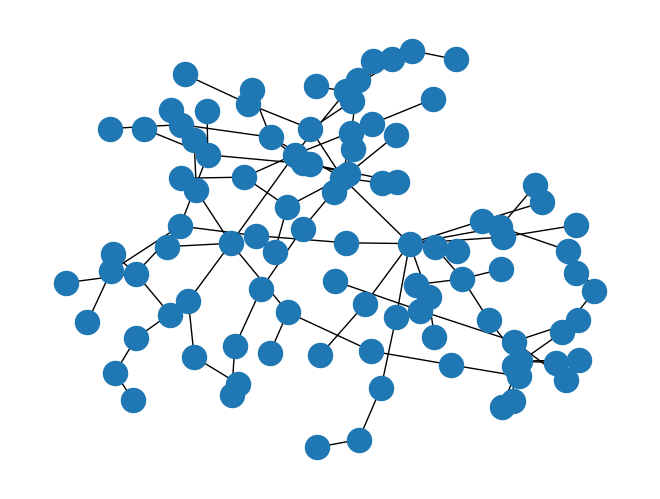

In [71]:
nx.draw(T)

In [80]:
class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))
        self.rank = [0] * n

    def union(self, x, y):
        x_parent = self.find(x)
        y_parent = self.find(y)

        if self.rank[x_parent] < self.rank[y_parent]:
            self.parent[x_parent] = y_parent
        elif self.rank[x_parent] > self.rank[y_parent]:
            self.parent[y_parent] = x_parent
        else:
            self.parent[y_parent] = x_parent
            self.rank[x_parent] += 1

    def find(self, x):
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]


def kruskal_mst(graph):
    edges = []
    for i in range(len(graph)):
        for j in range(i+1, len(graph)):
            edges.append((i, j, graph.edges[(i,j)]["weight"]))  # (page1, page2, weight)

    edges.sort(key=lambda x: x[2], reverse=True)  # Sort edges by weight

    mst = []
    uf = UnionFind(len(graph))

    for edge in edges:
        page1, page2, weight = edge
        if uf.find(page1) != uf.find(page2):
            uf.union(page1, page2)
            mst.append((page1, page2))

    return mst

In [85]:
def depth_first_traversal(graph, start_node):
    visited = set()
    stack = [start_node]
    reading_sequence = []

    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            reading_sequence.append(node)
            neighbors = graph[node]
            stack.extend(neighbors)

    return reading_sequence

In [86]:
def convert_to_adjacency_list(mst, num_pages):
    adj_list = [[] for _ in range(num_pages)]
    for edge in mst:
        page1, page2 = edge
        adj_list[page1].append(page2)
        adj_list[page2].append(page1)
    return adj_list

In [94]:
mst = kruskal_mst(G)
# mst = nx.maximum_spanning_tree(G).edges

# Assuming `mst` is the maximium spanning tree obtained using `kruskal_mst`
num_pages = len(G)
adj_list = convert_to_adjacency_list(mst, num_pages)

# Choose a root node (i.e. the first page in the reading sequence)
root_node = 0

# Perform depth-first traversal to obtain the reading sequence
reading_sequence = depth_first_traversal(adj_list, root_node)

print("Reading sequence:")
for node in reading_sequence:
    print(node, comm_dict[node])

Reading sequence:
0 4
14 4
49 4
5 2
97 2
85 4
95 4
75 2
27 2
3 1
64 2
89 2
9 3
58 2
87 3
50 4
81 3
35 4
26 4
29 0
69 3
74 4
47 3
42 2
16 2
13 4
82 4
45 3
21 3
83 2
43 2
2 3
22 0
54 0
15 4
88 4
28 4
39 1
20 1
30 1
10 1
31 1
53 2
37 2
55 4
79 1
86 1
99 1
41 1
1 1
62 1
23 0
19 3
76 1
24 1
71 1
18 3
56 3
63 3
32 3
48 1
65 1
46 1
84 1
78 3
66 3
7 3
4 2
60 2
12 1
67 1
93 1
57 1
25 0
36 0
34 0
98 0
11 0
40 2
70 4
90 4
80 0
73 1
68 0
91 0
38 3
61 1
33 2
44 2
77 2
51 2
17 2
92 1
96 1
8 4
52 1
72 1
59 4
94 4
6 4


Reading sequence: 0, 14, 49, 5, 97, 85, 95, 75, 27, 3, 64, 89, 9, 58, 87, 50, 81, 35, 26, 29, 69, 74, 47, 42, 16, 13, 82, 45, 21, 83, 43, 2, 22, 54, 15, 88, 28, 39, 20, 30, 10, 31, 53, 37, 55, 79, 86, 99, 41, 1, 62, 23, 19, 76, 24, 71, 18, 56, 63, 32, 48, 65, 46, 84, 78, 66, 7, 4, 60, 12, 67, 93, 57, 25, 36, 34, 98, 11, 40, 70, 90, 80, 73, 68, 91, 38, 61, 33, 44, 77, 51, 17, 92, 96, 8, 52, 72, 59, 94, 6

Reading sequence: 0, 14, 49, 5, 97, 85, 95, 92, 96, 75, 64, 89, 9, 58, 87, 81, 50, 47, 42, 16, 13, 82, 45, 38, 61, 35, 69, 74, 26, 29, 21, 83, 43, 22, 54, 28, 39, 20, 30, 78, 66, 7, 12, 67, 93, 57, 25, 36, 34, 98, 68, 11, 40, 70, 90, 80, 73, 91, 4, 60, 18, 56, 63, 32, 48, 65, 46, 84, 15, 88, 10, 31, 53, 55, 37, 79, 86, 99, 76, 41, 1, 62, 23, 19, 24, 71, 2, 33, 44, 77, 51, 17, 27, 3, 8, 52, 72, 59, 94, 6